In [1]:
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

import geopandas
import geoplot
import geoplot.crs as gcrs

import rasterio
import rioxarray

import json
import seaborn as sns

In [2]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')

Skipping field centroid: unsupported OGR type: 3


In [51]:
AEZ_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\Kenya_Agro-Ecological_Zones_Data.geojson')

In [52]:
AEZ_data.loc[:, 'AEZ_Code'] = AEZ_data.loc[:, 'AEZ_Code'].str.replace(' ', '', regex=True)

In [5]:
adm_data = geopandas.read_file('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\KE_boundaries\\adm_boundaries.geojson')
adm_data.drop(columns = ['end_date', 'country_code', 
                         'fewsnet_region', 'geographic_group', 
                         'es_name', 'fr_name', 'pt_name',
                         'ar_name', 'country', 'admin_0',
                         'admin_3', 'admin_4', 'layer_id',
                         'geographicunitsetversion_name', 'zone_type', 'urban_rural', 'start_month',
                         ], inplace=True)
adm_data = adm_data.explode()#.crs
adm_data.loc[:, 'centroid'] = adm_data.loc[:, 'geometry'].to_crs(crs=3857).centroid.to_crs('EPSG:4326')

Skipping field centroid: unsupported OGR type: 3


In [6]:
adm_data = adm_data.drop_duplicates(subset = ['admin_1'])

In [ ]:
import matplotlib.colors as mcolors


# Define a color mapping for your categories
categories = adm_data['admin_1'].unique()
color_map = {category: color for category, color in zip(categories, mcolors.CSS4_COLORS)}

# Map the colors to the GeoDataFrame
adm_data['color'] = adm_data['admin_1'].map(color_map)

# Plot using geoplot
geoplot.polyplot(
    adm_data,
    facecolor = adm_data['admin_1'],
    categorical=True,
    legend=True,
    legend_kwargs={'loc': 'upper right'},
    figsize=(10, 8)
)

plt.show()

: 

id                                                             3103
fnid                                                     KE2013A101
name                                                        Mombasa
unit_type_code                                               admin1
parent_id                                                    3413.0
start_date                                      2013-01-01 00:00:00
p_code                                                        KE001
full_name                                            Mombasa, Kenya
unit_type                                                   Admin 1
admin_1                                                     Mombasa
admin_2                                                        None
layer_name                                           KE_Admin1_2013
area                                                          228.0
attributes        { "FNID": "KE2013A101", "ADMIN0": "Kenya", "AD...
fid                                             

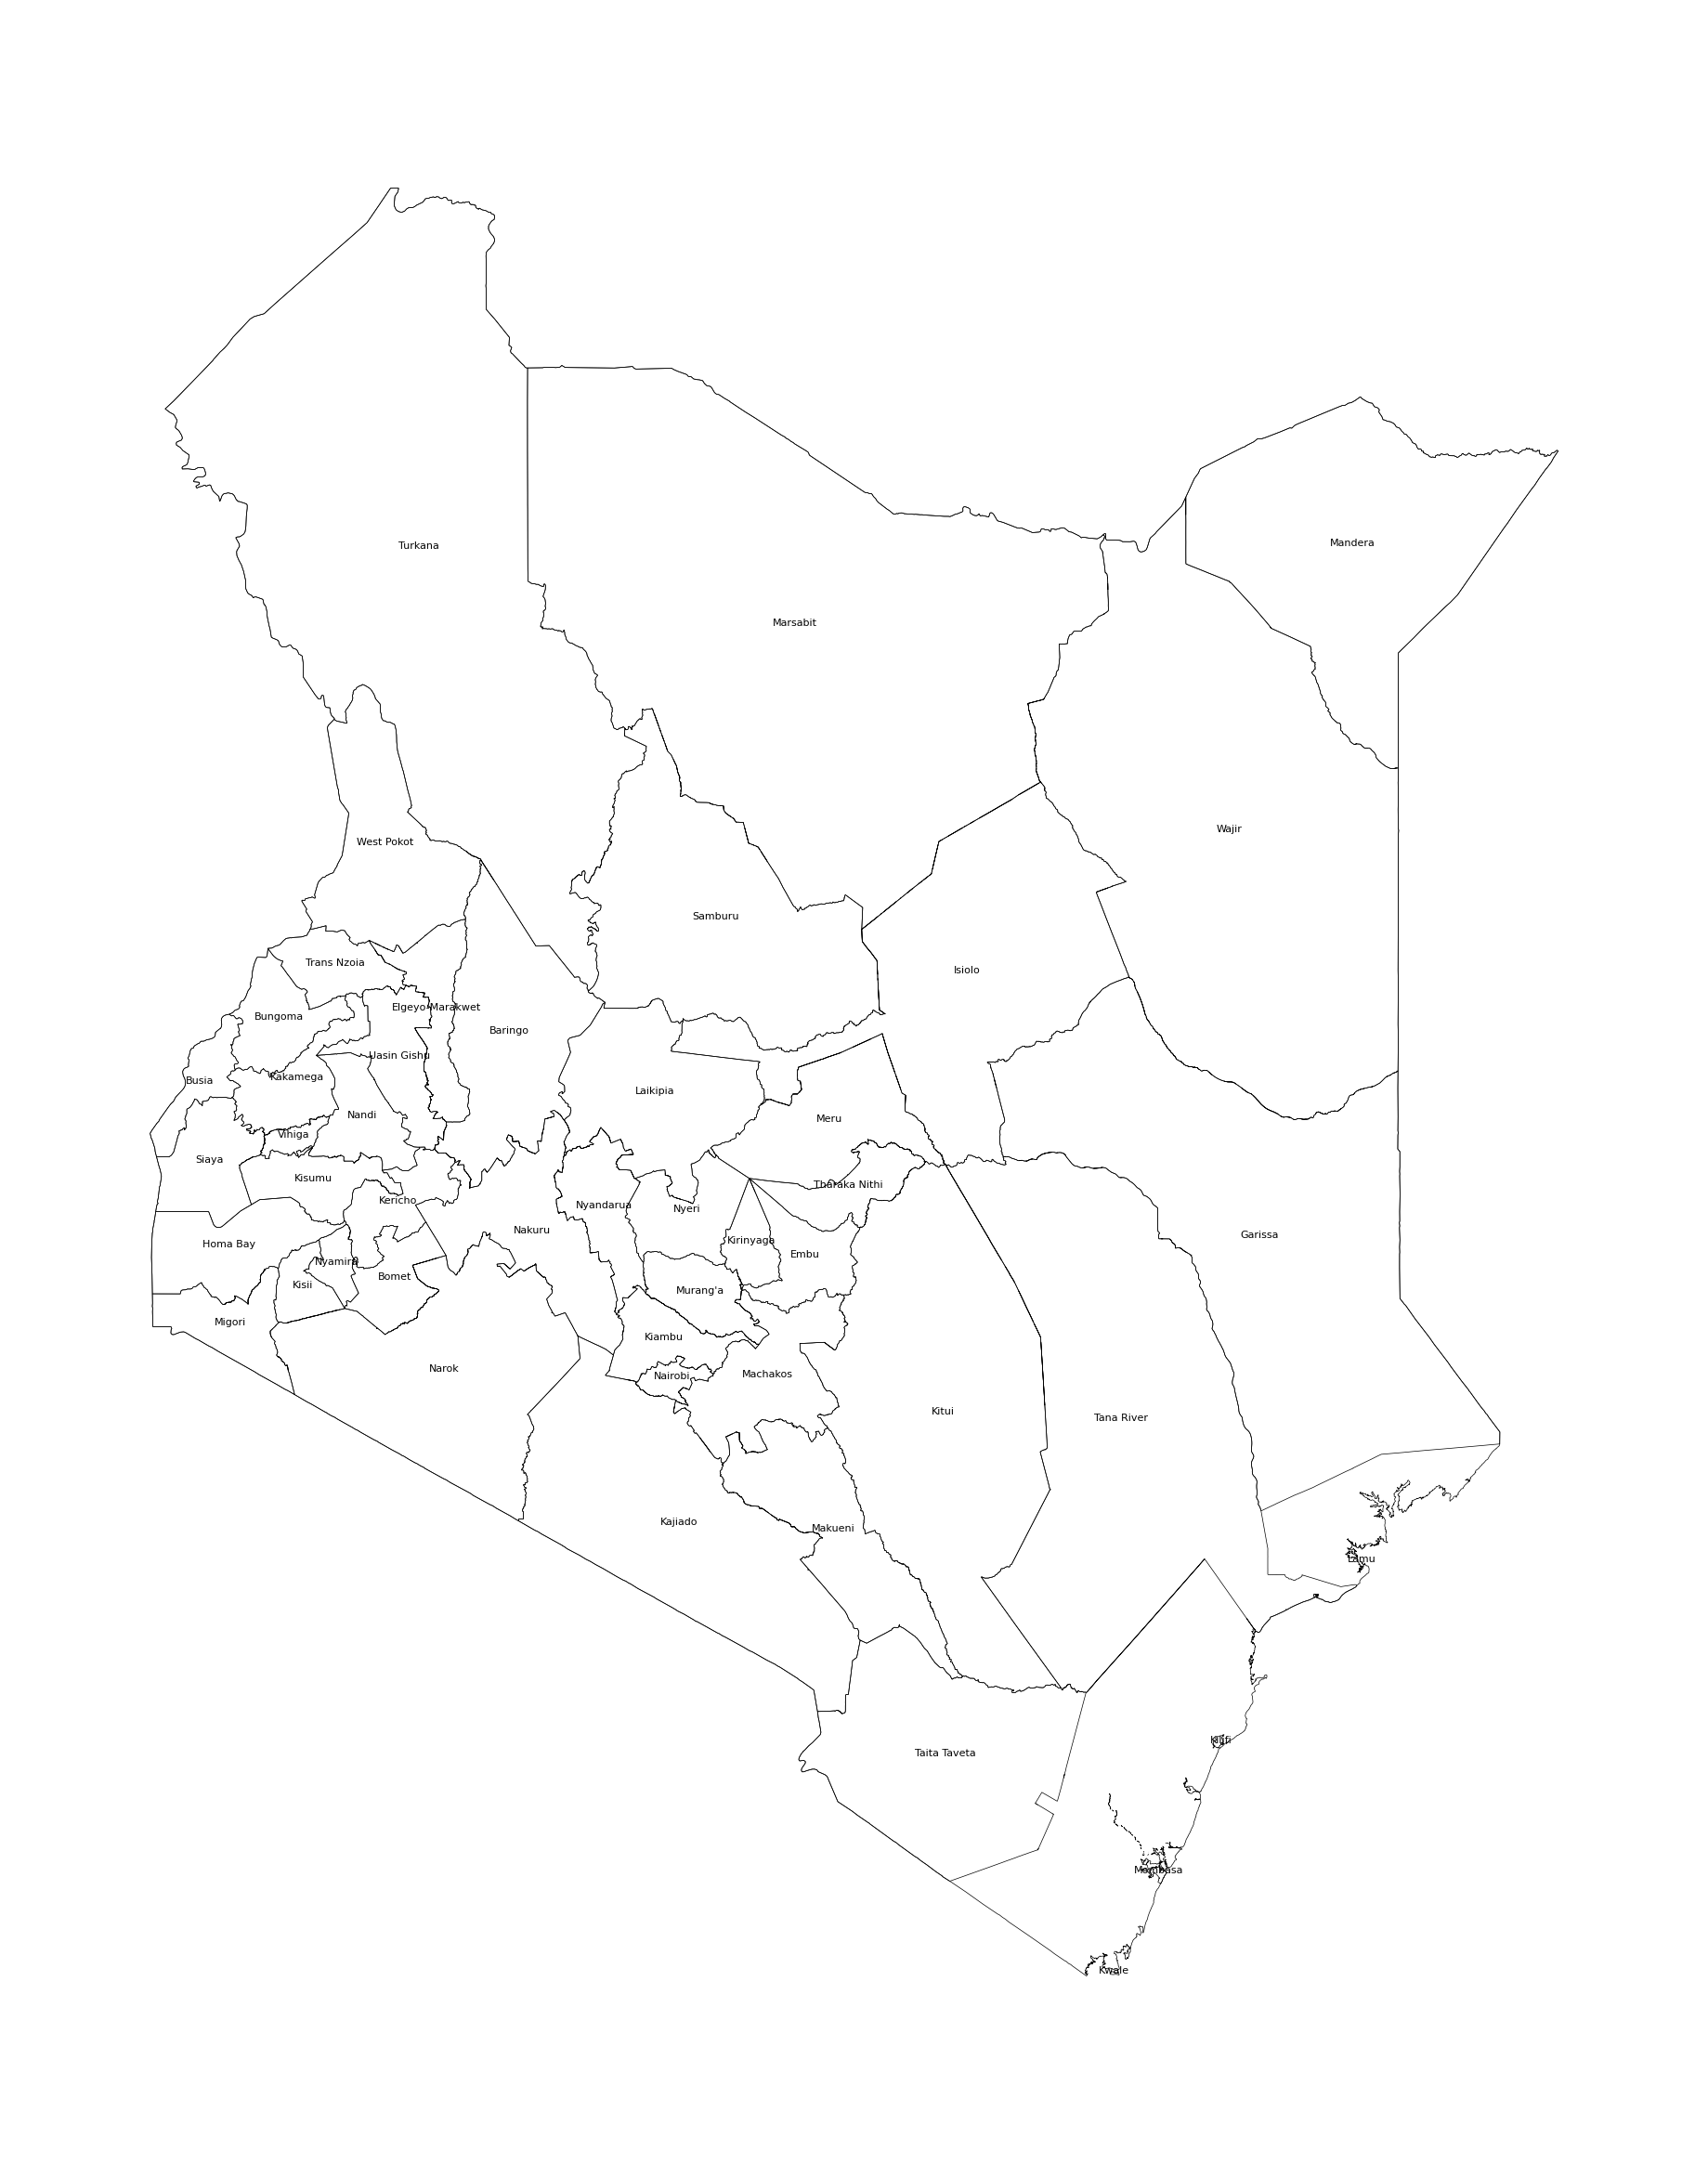

NameError: name 'yield_data_mean' is not defined

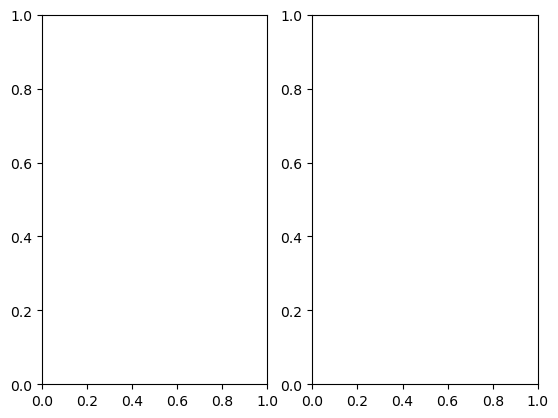

In [8]:
fig, axs = plt.subplots(1, 2)
norm = mpl.colors.Normalize(vmin=0.,vmax=3.5)
geoplot.choropleth(yield_data_mean.dropna(), hue='value', cmap='Oranges', ax=axs[0], legend=True, norm=norm, legend_kwargs={'fraction': 0.05})

In [9]:
calendar = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\yield_modelling\\data\\Crop_Calendar_Data.csv').drop(0)

In [10]:
def timedelta_from_month_day(months, days):
    return pd.to_datetime('2000-' + months.astype(str) + '-' + days.astype(str), format='%Y-%m-%d') - pd.to_datetime('2000-01-01', format='%Y-%m-%d')

In [11]:
#calendar

In [12]:
calendar.loc[:, 'Early sowing date'] = timedelta_from_month_day(calendar['Unnamed: 5'], calendar['Early Sowing'])
calendar.loc[:, 'Late sowing date'] = timedelta_from_month_day(calendar['Unnamed: 7'], calendar['Later Sowing'])
calendar.loc[:, 'Early harvest date'] = timedelta_from_month_day(calendar['Unnamed: 14'], calendar['Early harvest'])
calendar.loc[:, 'Late harvest date'] = timedelta_from_month_day(calendar['Unnamed: 16'], calendar['Late harvest'])

In [13]:
first_season = calendar.loc[calendar['Additional information'].str.contains('First season', case=False)]
second_season = calendar.loc[calendar['Additional information'].str.contains('Second season', case=False) | calendar['Additional information'].str.contains('Secind season', case=False)]

In [14]:
#first_season.columns.to_list()

In [15]:
seasons_stacked = first_season.merge(second_season[['AgroEcological Zone', 'Early sowing date', 'Late sowing date', 'Early harvest date', 'Late harvest date']],
                                     how='outer', suffixes=(' first', ' second'), on=['AgroEcological Zone'])
#seasons_stacked = seasons_stacked.loc[seasons_stacked['AgroEcological Zone Practices'].str.contains('maize', case=False)]

In [69]:
for code in ['Waterbody-IL5', 'Waterbody-IL6', 'Waterbody-IL7', 
             'Waterbody-IndianOcean', 'Waterbody-LH5', 
             'Waterbody-LM3', 'Waterbody-LM4', 'Waterbody-LM5',
             'Waterbody-LM6', 'Waterbody-LakeVictoria', 'Waterbody-UM5',
             'Waterbody-UM6']: #'TA1-2', 'TA0', 'TA1', 'TA2', 'NBO'
    AEZ_data = AEZ_data.loc[AEZ_data['AEZ_Code'] != code]

In [70]:
missed = 0
total = 0
for i, adm1 in enumerate(adm_data['admin_1'].unique()[:-1]):
    total += 1
    if ~np.any(seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains(adm1).values):
        print(adm1)
        #print(i)
        missed += 1
        adm_data.loc[adm_data['admin_1'] == adm1, 'missed'] = True
    else: 
        adm_data.loc[adm_data['admin_1'] == adm1, 'missed'] = False
        #print(seasons_stacked.loc[seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains(adm1), ['Early sowing date first', 'Late sowing date first', 'Early harvest date first', 'Late harvest date first', 'Early sowing date second', 'Late sowing date second', 'Early harvest date second', 'Late harvest date second']].drop_duplicates())
print(f'Missed {missed} out of {total} admin 1 regions')

Mombasa
Garissa
Wajir
Mandera
Marsabit
Isiolo
Tharaka Nithi
Makueni
Murang'a
Turkana
West Pokot
Trans Nzoia
Elgeyo-Marakwet
Bomet
Vihiga
Homa Bay
Migori
Nyamira
Missed 18 out of 46 admin 1 regions


In [84]:
seasons_stacked[seasons_stacked.loc[:, 'AgroEcological Zone Units'].str.contains('Tana river', case=False).values]

,Crop,AgroEcological Zone,AEZ_Code,Additional information,Early Sowing,Unnamed: 5,Later Sowing,Unnamed: 7,All year,Sowing rate,...,Comments AR,Comments RU,Early sowing date first,Late sowing date first,Early harvest date first,Late harvest date first,Early sowing date second,Late sowing date second,Early harvest date second,Late harvest date second
9,"Corn, sweet",Lowerland zone 3(L3),L3,First season. Short term maturing varieties eg...,15,4,30,4,no,25,...,NaN,NaN,105 days,120 days,196 days,227 days,NaT,NaT,NaT,NaT
10,"Corn, sweet",Lowerland zone 4(L4),L4,First season. Short term maturing varieties eg...,15,3,15,4,no,25,...,NaN,NaN,74 days,105 days,196 days,227 days,NaT,NaT,NaT,NaT


In [ ]:
geopladm_data.loc[adm_data['admin_1'] == 'Tana River']

,id,fnid,name,unit_type_code,parent_id,start_date,p_code,full_name,unit_type,admin_1,admin_2,layer_name,area,attributes,fid,geometry,centroid,missed
3,3115,KE2013A104,Tana River,admin1,3413.0,2013-01-01,KE004,"Tana River, Kenya",Admin 1,Tana River,None,KE_Admin1_2013,39233.0,"{ ""FNID"": ""KE2013A104"", ""ADMIN0"": ""Kenya"", ""AD...",38,"POLYGON ((39.04776 -0.00706, 39.05111 -0.00767...",POINT (39.4193 -1.52832),False


In [71]:
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL2(-3)', 'AEZ_Code'] = 'CL2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL3-4', 'AEZ_Code'] = 'CL3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LM4-5', 'AEZ_Code'] = 'LM4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH1-2', 'AEZ_Code'] = 'UH1'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH2-3', 'AEZ_Code'] = 'UH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM1-2', 'AEZ_Code'] = 'UM1'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM2-3', 'AEZ_Code'] = 'CL3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM2-4', 'AEZ_Code'] = 'UM3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM3-4', 'AEZ_Code'] = 'UM3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM4-5', 'AEZ_Code'] = 'UM4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UM5-6', 'AEZ_Code'] = 'UM5'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH3-4', 'AEZ_Code'] = 'LH3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'UH-LH3', 'AEZ_Code'] = 'LH3'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH2-3', 'AEZ_Code'] = 'LH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LH4-5', 'AEZ_Code'] = 'LH4'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'LM5-6', 'AEZ_Code'] = 'LM5'
#SAY TROPICAL ALPINE IS HIGHLAND
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA1-2', 'AEZ_Code'] = 'UH2' 
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA0', 'AEZ_Code'] = 'UH2'
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA1', 'AEZ_Code'] = 'UH2' #SAY TROPICAL ALPINE IS HIGHLAND
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'TA2', 'AEZ_Code'] = 'UH2'
#SAY Nairobi is lower highland
AEZ_data.loc[AEZ_data['AEZ_Code'] == 'NBO', 'AEZ_Code'] = 'LH2'

In [72]:
seasons_stacked['AEZ_Code'].unique()

array(['LH1', 'LH2', 'LH3', 'LH4', 'LM1', 'LM2', 'LM3', 'LM4', 'L2', 'L3',
       'L4', 'UH1', 'UH2', 'UM1', 'UM2', 'UM3', 'UM4'], dtype=object)

In [73]:
for code in range(8):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'CL{code}', 'AEZ_Code'] = f'L{code}'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'IL{code}', 'AEZ_Code'] = f'L{code}'

In [90]:
AEZ_data['AEZ_Code'].unique()[~np.isin(AEZ_data['AEZ_Code'].unique(), seasons_stacked['AEZ_Code'].unique())]

array(['L5', 'L6', 'LM5', 'LM6', 'UM5', 'LH0', 'UH0', 'UH3', 'L7', 'UM6',
       'LH5', 'UM0', 'LM7', 'UH4'], dtype=object)

In [121]:
for code in range(5, 8):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'L{code}', 'AEZ_Code'] = 'L4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'UM{code}', 'AEZ_Code'] = 'UM4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'LH{code}', 'AEZ_Code'] = 'LH4'
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'LM{code}', 'AEZ_Code'] = 'LM4'
for code in range(3, 5):
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'UH{code}', 'AEZ_Code'] = 'UH2'
for code in ['LH', 'UH', 'UM']:
    AEZ_data.loc[AEZ_data['AEZ_Code'] == f'{code}0', 'AEZ_Code'] = f'{code}1'

In [122]:
AEZ_data.loc[11102:11105, 'geometry'] = AEZ_data.loc[11102:11105, 'geometry'].buffer(0)
AEZ_bounds = AEZ_data.loc[:, ['AEZ_Code', 'geometry']].dissolve(by='AEZ_Code')

In [123]:
AEZ_with_date = AEZ_bounds.reset_index().merge(seasons_stacked, how='left', on='AEZ_Code').explode()#.dropna(subset='Crop')

In [124]:
delta_cols =  ['Early sowing date first', 'Late sowing date first',
               'Early harvest date first', 'Late harvest date first',
               'Early sowing date second', 'Late sowing date second',
               'Early harvest date second', 'Late harvest date second']
for col in delta_cols:
    AEZ_with_date.loc[:, col] = AEZ_with_date.loc[:, col].dt.days

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20892\2907304733.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 90  90  90  90 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105  74  74  74  74  74  74  74
  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74
  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74
  74  74  74  74  74  74  74  74  59  59  59  59  59  59  59  59  59  59
  59  59  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60
  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60  60
  60  60  60  60  74  74  74  74  74  74  74  74  74  74  74  74  74  74
  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74
  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74  74
  74  74 

In [125]:
no_dates = AEZ_with_date.loc[pd.isna(AEZ_with_date['Crop'])]

In [126]:
no_dates['AEZ_Code'].unique()
#no_dates = no_dates.loc[(no_dates['AEZ_Code'] == 'L5') | (no_dates['AEZ_Code'] == 'L6') | (no_dates['AEZ_Code'] == 'L7')]

array([], dtype=object)

In [127]:
adm_data = adm_data.loc[adm_data['name'] != 'Kenya']

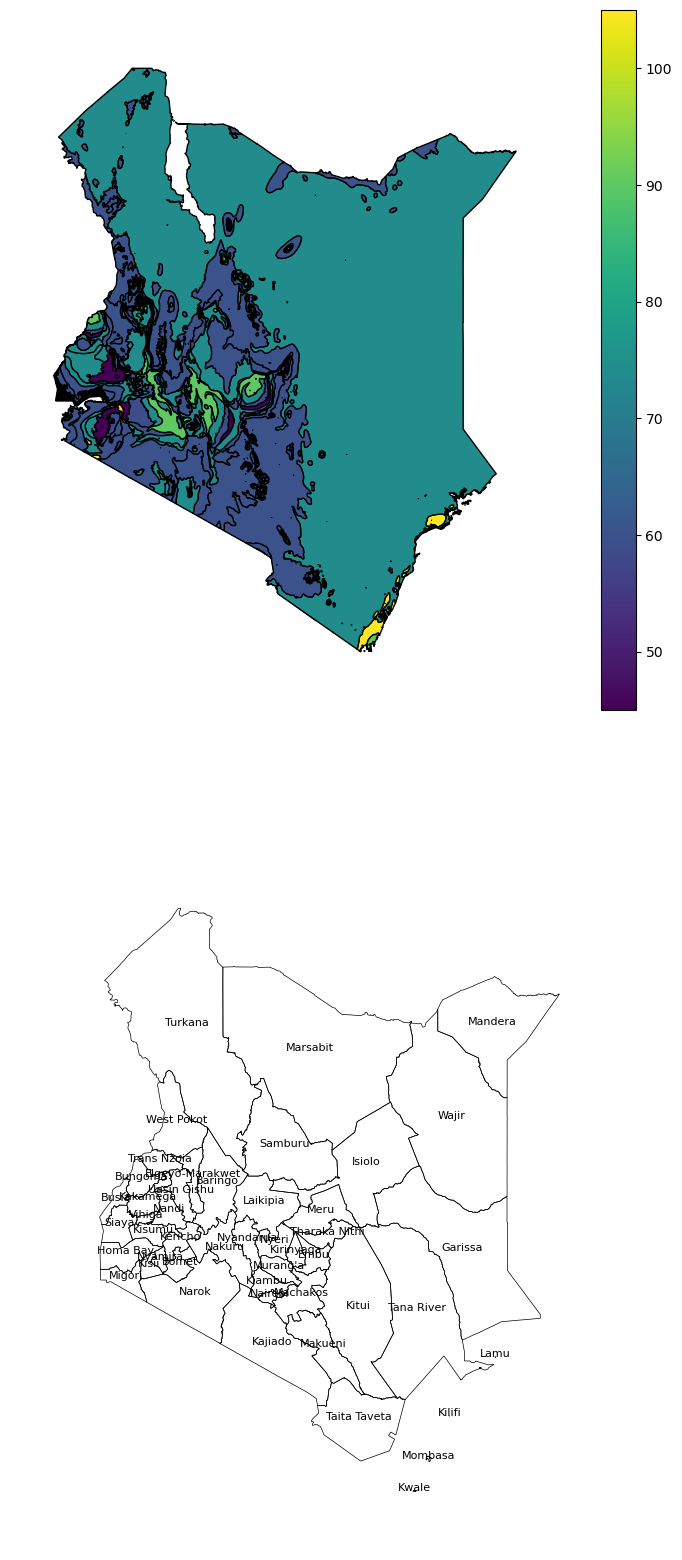

In [129]:
fig, axs = plt.subplots(2,1, figsize = (10, 20))
ax=axs[0]
geoplot.polyplot(no_dates, linewidth = 0.5, facecolor = 'red', ax=ax)
geoplot.polyplot(adm_data.loc[adm_data['missed'] == False], facecolor='black', ax=ax)
geoplot.choropleth(AEZ_with_date.dropna(subset=['Crop']), 
                   hue='Early sowing date first', cmap='viridis', 
                   legend=True, ax=ax)
ax=axs[1]
geoplot.polyplot(adm_data, edgecolor = 'black', linewidth = 0.5, ax = ax)
for index, row in adm_data.iterrows():
    #print(row)
    #print(row['centroid'])
    plt.text(row['centroid'].x, row['centroid'].y, row['admin_1'], fontsize=8, ha='center')

In [94]:
adm1 = ['Isiolo', 'Turkana', 'Marsabit', 'Wajir', 'Mandera', 'Garissa'][0]#, 'Kilifi', 'Mombasa', 'Kwale', 'Lamu']
AEZ_data[AEZ_data['County'].str.contains(adm1, case=False)]['AEZ_Code'].unique()

array(['L6', 'L7', 'LM5', 'LM6', 'UM5', 'UM6'], dtype=object)

In [28]:
#hit = adm_data.loc[adm_data['missed'] == False]
#geoplot.polyplot

In [29]:
#geoplot.choropleth(AEZ_with_date.dropna(subset=['Crop']), hue='Early sowing date first', cmap='viridis', legend=True, figsize=(10, 8))

In [92]:
#AEZ_data.loc[AEZ_data['AEZ_Code'] == 'CL3']#.columns

In [93]:
#AEZ_bounds.index.values#['AEZ_Code'].values#.explode()

In [82]:
#geoplot.polyplot(AEZ_bounds.explode(), edgecolor = 'black', linewidth = 0.5)


In [82]:
np.any(calendar.loc[:, 'AgroEcological Zone Units'].str.contains(adm_data['admin_1'].values[5]).values)

np.True_

In [12]:
#adm_data['admin_1']

In [ ]:
pd.to_datetime(calendar['Early Sowing Date'].astype(str) + '-' + df['Early Sowing Date'].astype(str), format='%m-%d')


In [14]:
#calendar.loc[:, 'Early Sowing Date'] = pd.to_timedelta(calendar['Early Sowing'].astype(int), 'D') + pd.to_timedelta(calendar['Unnamed: 4'].astype(int), 'M')